# Child Protection Plan (CPP) - Demographic Analysis

# Import Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')
plt.style.use('tableau-colorblind10')
color='#702A7D'
grey_color = '#A9A9A9'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query for Import

In [3]:
# CPP Data
cpp_query = """
SELECT
  a.person_id, a.YearOfBirth
  ,a.PCArea, a.EthnicOrigin, a.CPP_Category
  ,a.StartDate, a.EndDate
  ,DATE(p.birth_datetime) AS DateOfBirth
  ,p.gender_source_value AS Gender
FROM
    yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CPP AS a
LEFT JOIN
    yhcr-prd-bradfor-bia-core.CB_2649.person AS p
ON
    a.person_id = p.person_id
"""

# Load Queries into dataframes

In [4]:
cpp = pandas_gbq.read_gbq(cpp_query)

Downloading: 100%|██████████|


## CPP - Child Protection Plan

In [5]:
# First few rows of cpp
cpp.head()

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Gender
0,C9B1DB2054F1D69B674BA78B879110113E7EBB6CF229D4...,2021,,Asian/British Asian - Pakistani,Neglect,2021-01-26,NaT,2021-02-15,F
1,CE05511AE9E947ED3248AD446BFCFBBCBB0E07FDC458A9...,2021,,White - British,Emotional Abuse,2021-01-12,NaT,2021-05-15,F
2,A53B7CB131455D1FF1868DD79CF73BCD273FC814D512FB...,2021,,White - British,Neglect,2021-05-06,NaT,2021-05-15,F
3,A8761FA45B1F1618DDB6D1AC16A4EF230E25BC0BF59273...,2021,,White - British,Emotional Abuse,2020-11-05,NaT,2021-04-15,F
4,FC64B02447FD8AA2E9CAC290A5BA7A183F70EBC9225EE3...,2021,,Other Ethnic Group,Emotional Abuse,2020-11-24,NaT,2021-03-15,M


In [6]:
# CPP columns overview
cpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     4112 non-null   object
 1   YearOfBirth   4112 non-null   Int64 
 2   PCArea        4112 non-null   object
 3   EthnicOrigin  4112 non-null   object
 4   CPP_Category  4112 non-null   object
 5   StartDate     4112 non-null   dbdate
 6   EndDate       3216 non-null   dbdate
 7   DateOfBirth   4110 non-null   dbdate
 8   Gender        4109 non-null   object
dtypes: Int64(1), dbdate(3), object(5)
memory usage: 293.3+ KB


In [7]:
# Total null values per column
cpp.isnull().sum()

person_id         0
YearOfBirth       0
PCArea            0
EthnicOrigin      0
CPP_Category      0
StartDate         0
EndDate         896
DateOfBirth       2
Gender            3
dtype: int64

In [8]:
# Locate entries that have missing DateOfBirth
cpp.loc[cpp.DateOfBirth.isnull()]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Gender
1643,E1ADD1120F8811711A506B9BE016B111BBCEBBC6ACAAE8...,2008,BD3,Gypsy/Roma,Emotional Abuse,2020-01-22,NaT,NaT,None
2665,5FC5E11E7C47ADFA281F362ED6DD92390BB98C59DCB796...,2003,BD5,Gypsy/Roma,Emotional Abuse,2017-08-03,2018-07-04,NaT,None


In [9]:
# Fill the missing date of birth as 15th of January. All DoB have day of birth as 15th
cpp.loc[1643, 'DateOfBirth'] = '2008-01-15'
cpp.loc[2665, 'DateOfBirth'] = '2003-01-15'

In [10]:
# Locate entries that have missing DateOfBirth
cpp.loc[cpp.DateOfBirth.isnull()]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Gender


In [11]:
# Unique values in the gender column
cpp.Gender.unique()

array(['F', 'M', None, '1', '2', 'Female', 'Male'], dtype=object)

In [12]:
# Create a mapping dictionary to clean the gender column
gender_mapping = {
    'F': 'Female',
    'M': 'Male',
    '1': None,
    '2': None,
    'Male': 'Male',
    'Female': 'Female',
    'U': None,
    'N': None,  
    'null': None,
    None: None
}

# clean the gender column

cpp['Gender'] = cpp['Gender'].map(gender_mapping)

In [13]:
# Convert the dates to datetime format
cpp['StartDate'] = pd.to_datetime(cpp['StartDate'])
cpp['EndDate'] = pd.to_datetime(cpp['EndDate'])
cpp['DateOfBirth'] = pd.to_datetime(cpp['DateOfBirth'])

# Verify
cpp.dtypes

person_id               object
YearOfBirth              Int64
PCArea                  object
EthnicOrigin            object
CPP_Category            object
StartDate       datetime64[ns]
EndDate         datetime64[ns]
DateOfBirth     datetime64[ns]
Gender                  object
dtype: object

In [14]:
# Timeline of the dataset
minimum_start_date = np.min(cpp['StartDate'])
last_start_date = np.max(cpp['StartDate'])

print(f"The CPP Data starts from: {minimum_start_date}")
print(f"The last start date is: {last_start_date}")

The CPP Data starts from: 2017-04-03 00:00:00
The last start date is: 2021-06-09 00:00:00


In [15]:
# Check for duplicates
cpp.duplicated().sum()

1

In [16]:
# Locate the duplicate entry
cpp.loc[cpp.duplicated(keep=False)]

,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Gender
252,FF716DF11C69D25EF44E3D80ABD4F6A825C39C4A1DE162...,2006,BD10,White - British,Emotional Abuse,2021-06-08,NaT,2006-04-15,Female
253,FF716DF11C69D25EF44E3D80ABD4F6A825C39C4A1DE162...,2006,BD10,White - British,Emotional Abuse,2021-06-08,NaT,2006-04-15,Female


In [17]:
# Drop the duplicate entry
cpp.drop_duplicates(inplace=True)

In [18]:
# Number of Persons in the CPP
print(f'Number of Unique IDs: {cpp.person_id.nunique()}')

Number of Unique IDs: 3858


In [19]:
# check for duplicate person_id to see if there are re-entries
print(f"Number of duplicate person_ids: {cpp.duplicated('person_id').sum()} \n")

duplicate_person_ids = cpp.loc[(cpp.duplicated('person_id', keep=False))].sort_values(by='person_id')
duplicate_person_ids

Number of duplicate person_ids: 253 



,person_id,YearOfBirth,PCArea,EthnicOrigin,CPP_Category,StartDate,EndDate,DateOfBirth,Gender
2535,008C85F7AFFEBB0EE13C2E9AE8B2B2200F6C82CB6E669D...,2012,BD4,White - British,Emotional Abuse,2018-11-02,2019-01-21,2012-12-15,Male
2487,008C85F7AFFEBB0EE13C2E9AE8B2B2200F6C82CB6E669D...,2012,BD4,White - British,Sexual Abuse,2017-12-12,2018-04-18,2012-12-15,Male
2725,01372244D0AF88B0B79598275F53994EE3AC6F6E660F49...,2018,BD5,Mixed - White/Black Caribbean,Emotional Abuse,2018-05-08,2018-07-31,2018-01-15,Female
2708,01372244D0AF88B0B79598275F53994EE3AC6F6E660F49...,2018,BD5,Mixed - White/Black Caribbean,Emotional Abuse,2020-06-04,2021-05-14,2018-01-15,Female
2194,022AD16AEA5FE467DFCB98859000673FBCF8744A266FE4...,2014,BD4,White - British,Emotional Abuse,2019-02-14,2019-10-10,2014-05-15,Male
...,...,...,...,...,...,...,...,...,...
1169,FCE6CBBDA7F79D00DD3A7F966318B617AFB52FB114ADE1...,2007,BD2,Black/Black British - African,Physical Abuse,2018-11-26,2019-06-13,2007-01-15,Male
3202,FD9775045A482617E039517008FC46729078E806E008CA...,2017,BD6,White - British,Emotional Abuse,2019-07-01,2019-08-28,2017-01-15,Female
3041,FD9775045A482617E039517008FC46729078E806E008CA...,2017,BD6,White - British,Neglect,2018-12-18,2019-02-27,2017-01-15,Female
1768,FF3734FC4D837A4D12ED15F152E413E9FDFBE5A49162D6...,2006,BD3,Asian/British Asian - Other,Emotional Abuse,2017-05-03,2018-05-21,2006-08-15,Male


In [20]:
# Display top 10 Persons with re-entries
duplicate_person_ids.person_id.value_counts().head(10)

person_id
F83D53AE95DE879DBD5EF8E60166668CE07198C10A721F1CE4F3A81111DDA232    3
C18573ADE1394BFAE179CF2E9D781B4C4DFB1CD5050729B01CD77F749BD2250A    3
FAE156C2E482B67D764084BF693CD413B6F1E4639855FFF5694977EDA595AAE2    3
1731ED06071796047178F013B2FF00E3F9C488574BF7BB7D1545E81458207084    3
A22A659306B82A78378A21AEE2CB4AFBCBA18A96F7410D17BCC49111846DA951    3
AEA57FAB558A42E219DA6FB1981DA25F20145FFC1E950DCC42D62664678ED945    2
B09B1EA9CA9CEBE0B84B15B598EBCB4E41744F01A41B763D49014D364ECF8178    2
B091E51CDA2571F93BB0B62A80A8F8BEDB09999F62EAA7D5286FDC9223D8F8E1    2
B0398D79BAFA5C2CB176DD699BD3B1A93BC7D18B29C4DCAECE492EEA79EC7B2C    2
AF45410622CFBD91E685E493C0F5C9234627D4BC373ADCE19F9713139A69B1F5    2
Name: count, dtype: int64

________
### **Observations:**
* We have 3858 unique persons in the dataset
* We have one duplicate entries 
* 253 persons (6.6%) have re-entered into the protection system. The maximum number of re-entry is 3

**Data Changes:**
* Removed the duplicate entry
* Assigned January to get date of birth of two children missing DoBs
* Converted dates to datetime format

## Data Exploration

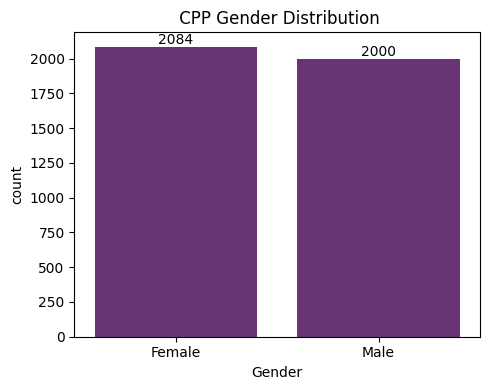

In [46]:
# Gender Distribution
plt.figure(figsize=(5,4))
ax = sns.countplot(data=cpp, 
                   x='Gender',
                   color=color)
ax.set_title(' CPP Gender Distribution')
ax.set_xlabel('Gender')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

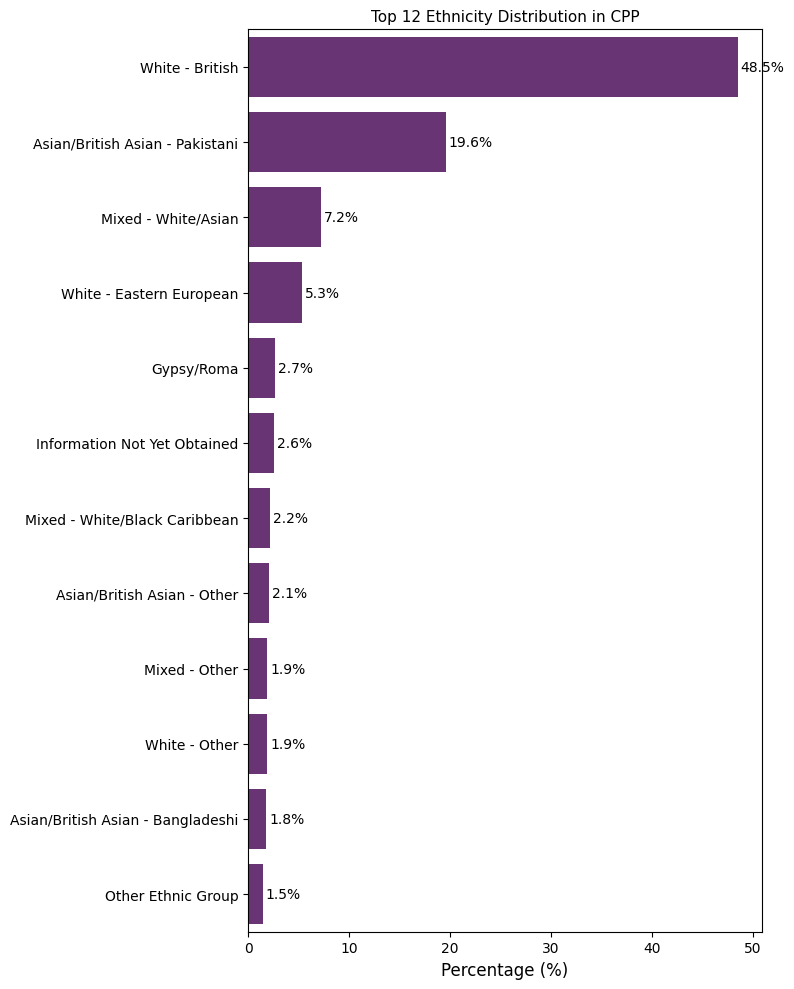

In [81]:
# Ethnicity Distribution
plt.figure(figsize=(8, 10))

# Calculate percentages
ethnicity_counts = cpp['EthnicOrigin'].value_counts(normalize=True) * 100
ethnicity_order = ethnicity_counts.sort_values(ascending=False).index[:12]

# Filter to top 12 ethnicities
top_ethnicity_counts = ethnicity_counts[ethnicity_order]

# Create the plot with percentages
ax = sns.barplot(
    x=top_ethnicity_counts.values,
    y=ethnicity_order,
    color=color
)
ax.set_title('Top 12 Ethnicity Distribution in CPP', fontsize=11)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel(None)
# Add percentage labels to the bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(
        width + 0.3,
        p.get_y() + p.get_height()/2,
        f'{width:.1f}%',  
        ha='left',
        va='center',
        fontsize=10)
plt.tight_layout()
plt.savefig('../figs/CPP_Ethinicity_Dist.png', dpi=300)
plt.show()

___
* **White-British and Asian/British Pakistani** children accounted for **68%** of the children that entered the CPP from April 2017
* **White-British** children alone accounts for **48.48% - almost half**. This is quite understandable given the fact that the dataset is from England.

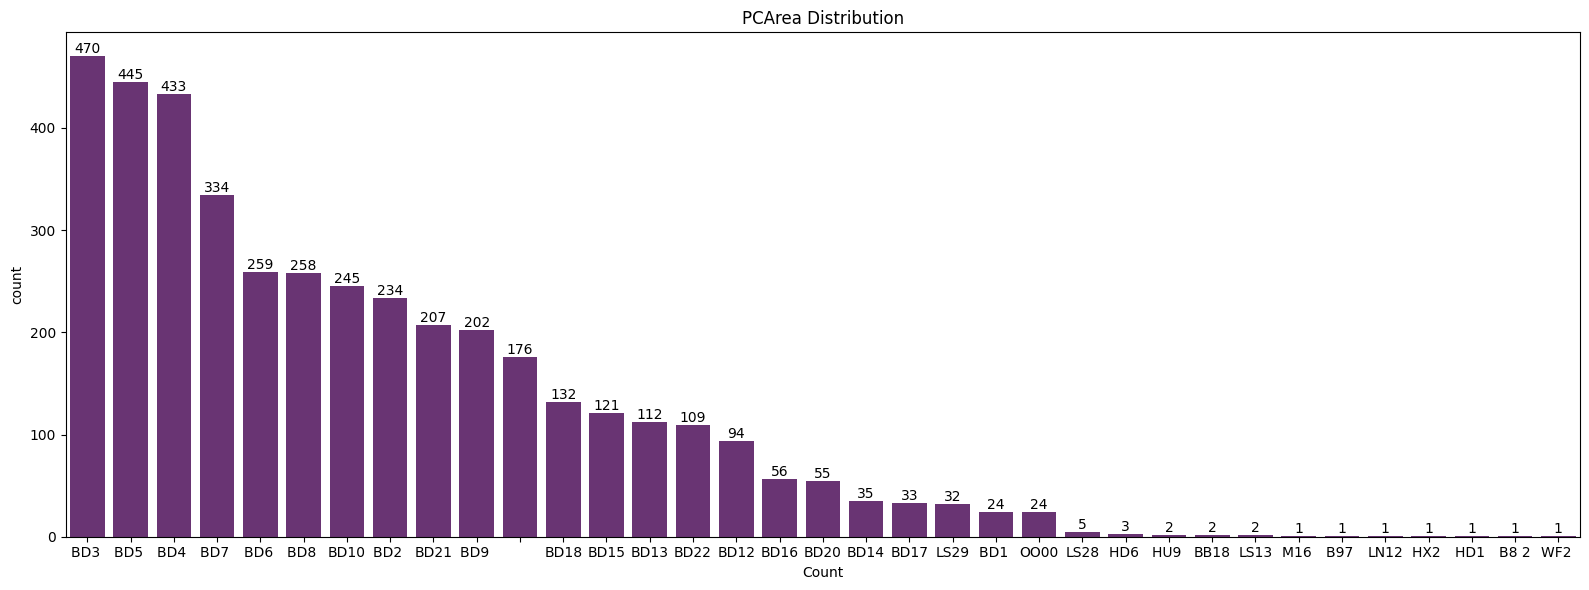

In [23]:
#### PCArea Distribution
plt.figure(figsize=(16,6))
ax = sns.countplot(data=cpp, 
                   x='PCArea',
                   order= cpp['PCArea'].value_counts().sort_values(ascending=False).index,
                   color=color)
ax.set_title('PCArea Distribution')
ax.set_xlabel('Count')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

In [24]:
# Statistics of the Area Distribution
print(f"Average number of children in CPP per area: {cpp.PCArea.value_counts().mean()}")
print(f"Median number of children in CPP per area: {cpp.PCArea.value_counts().median()}")
print(f"STD of children in CPP per area: {round(cpp.PCArea.value_counts().std(),2)}")

Average number of children in CPP per area: 117.45714285714286
Median number of children in CPP per area: 55.0
STD of children in CPP per area: 140.82


______

* The high STD from the mean suggests there is significant variablity across the different PCAreas. **470 in BD3, 24 in BD1** is an example of this variance.

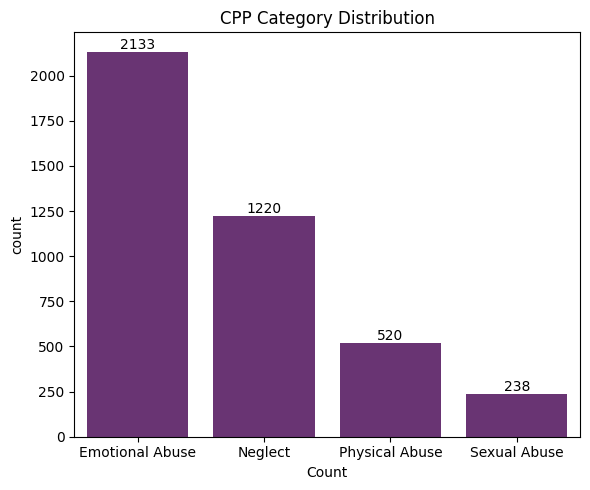

In [25]:
"""
What's the most common reason for intervention?

"""

# CPP Category Distribution
plt.figure(figsize=(6,5))
ax = sns.countplot(data=cpp, 
                   x='CPP_Category',
                   order= cpp['CPP_Category'].value_counts().sort_values(ascending=False).index,
                   color=color)
ax.set_title('CPP Category Distribution')
ax.set_xlabel('Count')

# Add counts to the bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

_______

**Observation:**
* **Emotional Abuse** accounts for just more than half **(51.79%)** of the reasons for intervention.

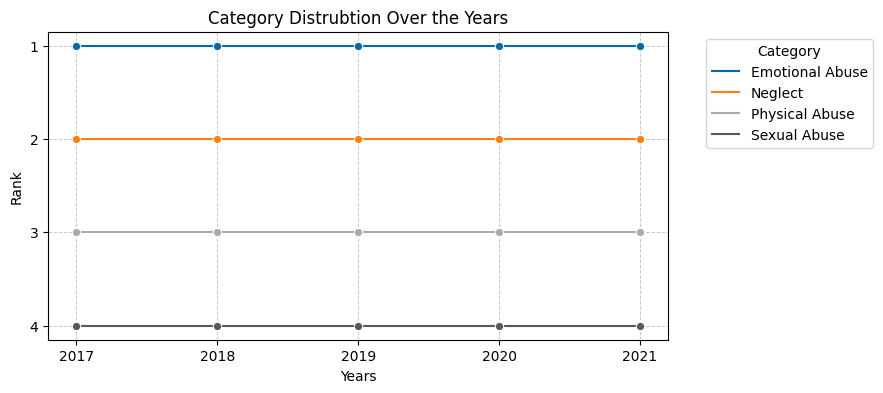

In [26]:
# Category Distribution over the Years
# Get Year value
cpp['Year'] = cpp['StartDate'].dt.year

# Group by year and category and count entries
category_counts = cpp.groupby(['Year', 'CPP_Category']).size().reset_index(name='count')

#Rank categories within each year
category_counts['rank'] = category_counts.groupby('Year')['count'].rank(method='first', ascending=False)

# PLOT
plt.figure(figsize=(8,4))

# Create the bump chart
sns.lineplot(data=category_counts, x='Year', y='rank', hue='CPP_Category', marker='o')

# Set x-axis to integer value only
plt.xticks(category_counts['Year'].unique())

# Set y-axis to integer value only
plt.yticks(category_counts['rank'].unique())

# Invert y-axis to have highest rank at the top
plt.gca().invert_yaxis()

# Add Labels and titles
plt.title('Category Distrubtion Over the Years')
plt.xlabel('Years')
plt.ylabel('Rank')
plt.grid(True, which='both', linestyle='--', linewidth=.7, alpha=.7)
plt.legend(title='Category', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

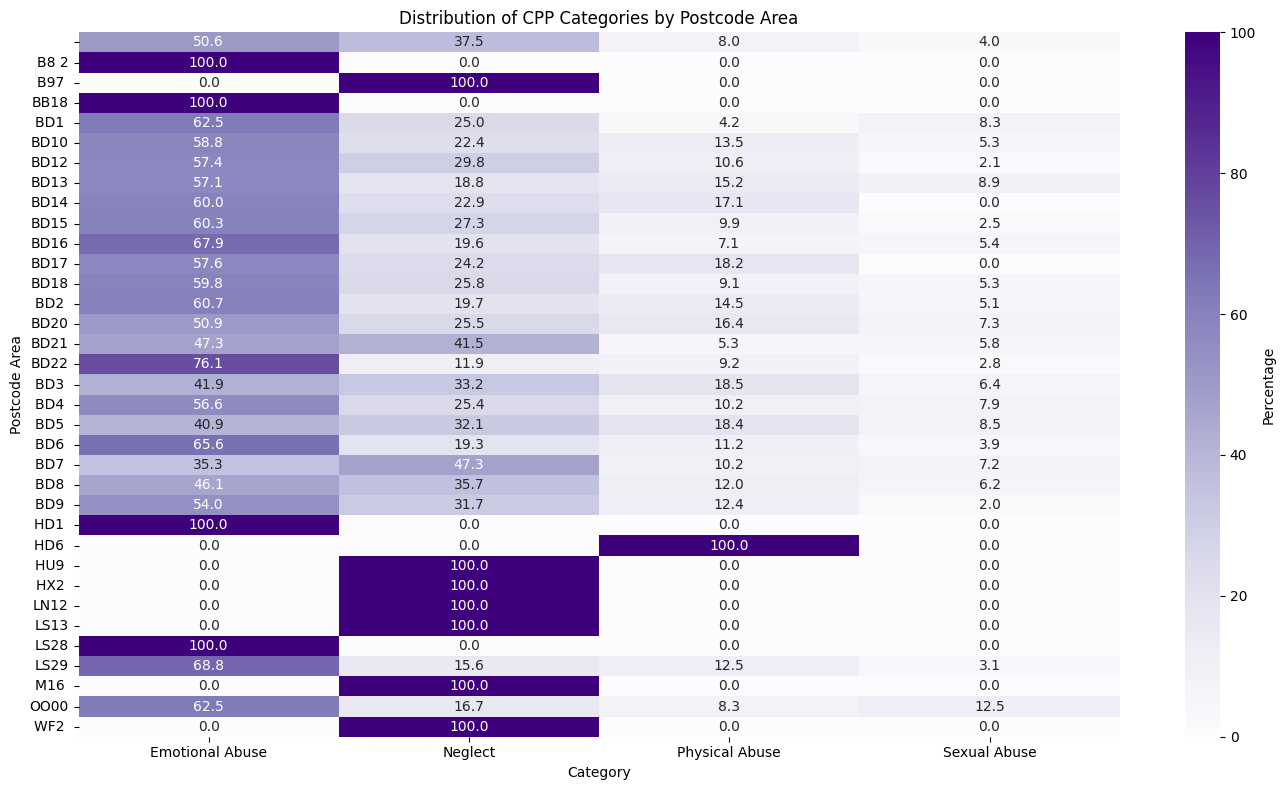

In [27]:
"""
Is there pattern(s) in intervention reasons across areas?

"""


# Create a pivot table to count occurrences of each categories in each postcode area
pivot_table = cpp.pivot_table(index='PCArea', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages
percentage_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of CPP Categories by Postcode Area')
plt.xlabel('Category')
plt.ylabel('Postcode Area')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

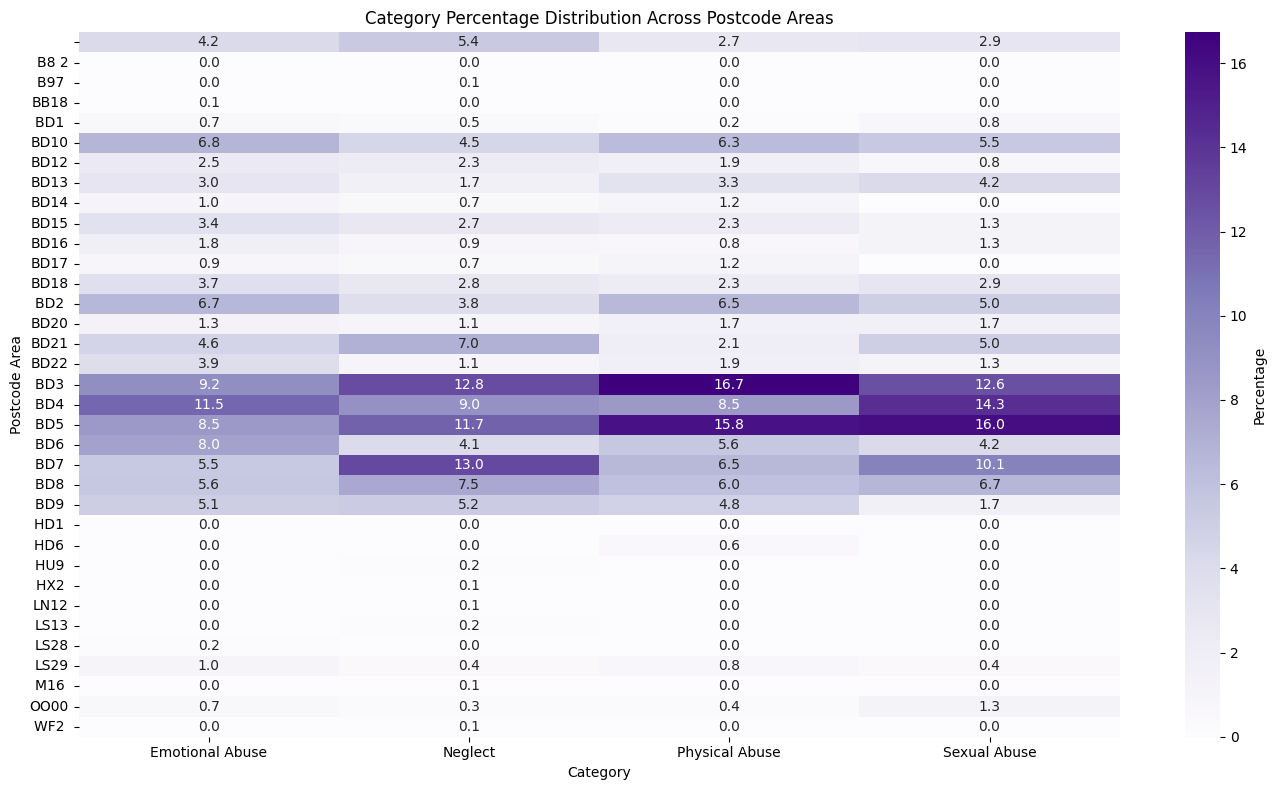

In [28]:
# Create a pivot table to count occurrences of each reason in each postcode area
pivot_table = cpp.pivot_table(index='PCArea', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_category = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_category, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Category Percentage Distribution Across Postcode Areas')
plt.xlabel('Category')
plt.ylabel('Postcode Area')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

______
The above plots helps us see how the CPP categories are distributed at each postcode and across all postcodes areas<br>


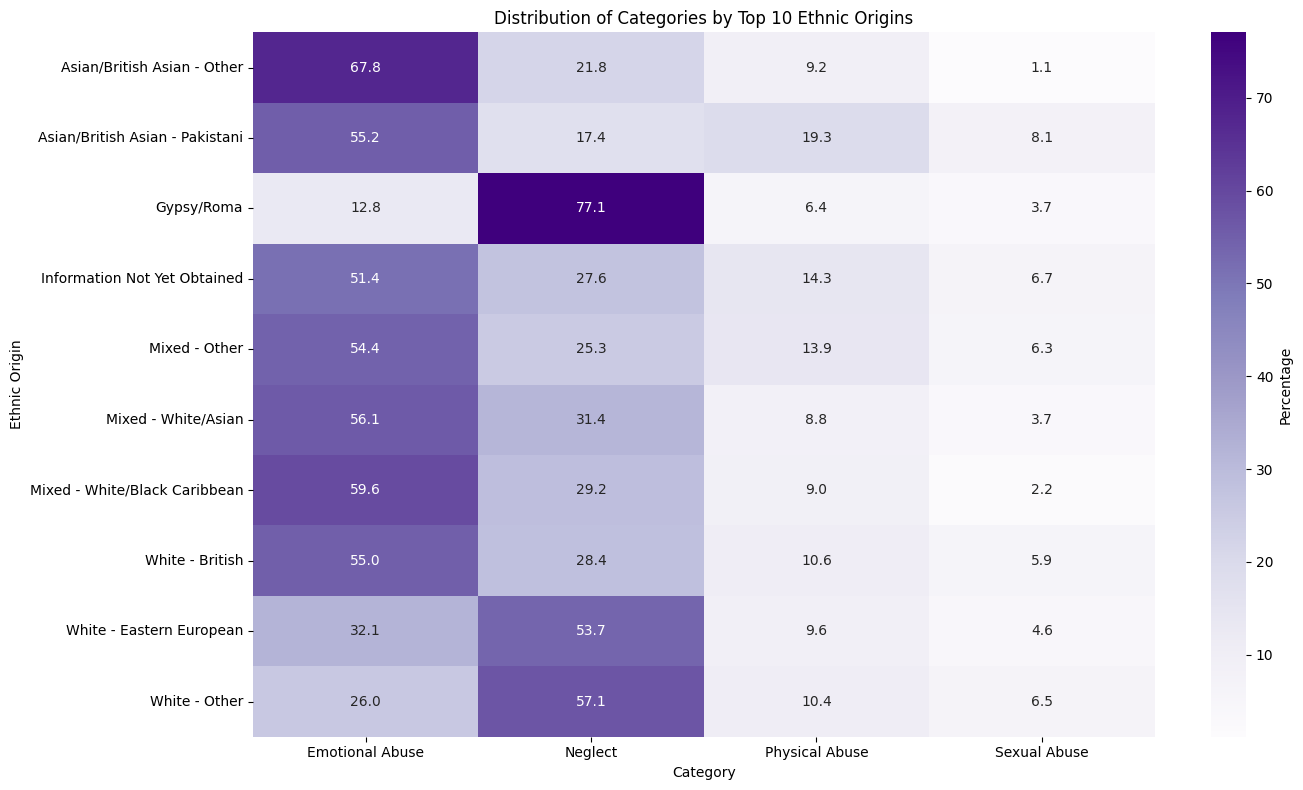

In [29]:
"""
What's the distribution of the categories by the Ethnicity and across Ethnicities?

"""
# Identify the top 10 most frequent ethnic origins
top_ethnic_origins = cpp['EthnicOrigin'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 ethnic origins
filtered_cpp = cpp[cpp['EthnicOrigin'].isin(top_ethnic_origins)]

# Create a pivot table to count occurrences of each categories  in each Ethnic Origin
pivot_table_ethnicity = filtered_cpp.pivot_table(index='EthnicOrigin', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_ethnic_origin = pivot_table_ethnicity.div(pivot_table_ethnicity.sum(axis=1), axis=0) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_ethnic_origin, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of Categories by Top 10 Ethnic Origins')
plt.ylabel('Ethnic Origin')
plt.xlabel('Category')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

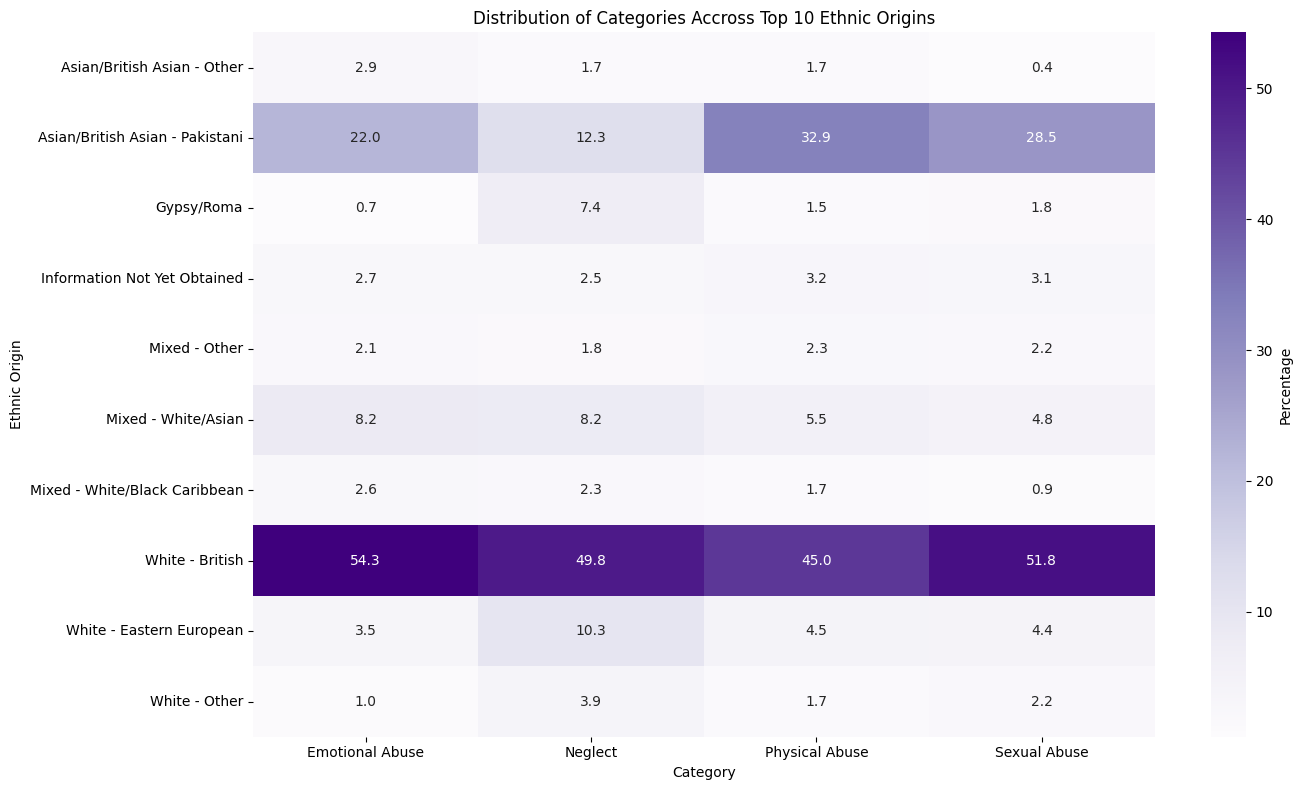

In [30]:
# Identify the top 10 most frequent ethnic origins
top_ethnic_origins = cpp['EthnicOrigin'].value_counts().nlargest(10).index

# Filter the DataFrame to include only the top 10 ethnic origins
filtered_cpp = cpp[cpp['EthnicOrigin'].isin(top_ethnic_origins)]

# Create a pivot table to count occurrences of each categories  in each Ethnic Origin
pivot_table_ethnicity = filtered_cpp.pivot_table(index='EthnicOrigin', columns='CPP_Category', aggfunc='size', fill_value=0)

# Convert counts to percentages by categories
percentage_table_by_ethnic_origin = pivot_table_ethnicity.div(pivot_table_ethnicity.sum(axis=0), axis=1) * 100

# Plot a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(percentage_table_by_ethnic_origin, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Percentage'})
plt.title('Distribution of Categories Accross Top 10 Ethnic Origins')
plt.ylabel('Ethnic Origin')
plt.xlabel('Category')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

It's not surprising that the White-British and Asian/British-Pakistani are dominating the categories across all ethnicites giving that they account for 68% of all entries.<br>
Hence, it's better to look at this at the POV of each Ethnic group.
_______
### What is the distribution of the Children in terms of Age at their time of entry into the intervention?

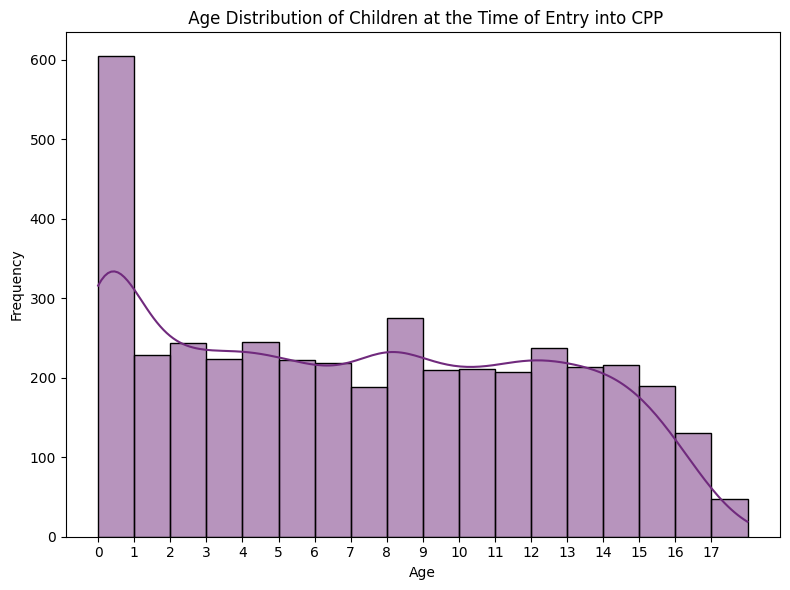

In [31]:
"""
What is the distribution of the Children in terms of Age at their time of entry into the intervention?

"""

# Calculate the age of each children by substracting their birth year from the year they entered the CPP
cpp['AgeAtEntry'] = cpp.apply(
    lambda row: relativedelta(row['StartDate'], row['DateOfBirth']).years,
    axis=1
).astype('int')


max_age = cpp['AgeAtEntry'].max()

# Plot the distribution of the Ages
plt.figure(figsize=(8,6))
sns.histplot(data=cpp, x='AgeAtEntry', color=color, kde=True, bins=range(0, cpp['AgeAtEntry'].max() + 1));
plt.title(' Age Distribution of Children at the Time of Entry into CPP')
plt.ylabel('Frequency')
plt.xlabel('Age')

# Set x-ticks to be integers
plt.xticks(np.arange(0, max_age, step=1))
plt.tight_layout()
plt.show()

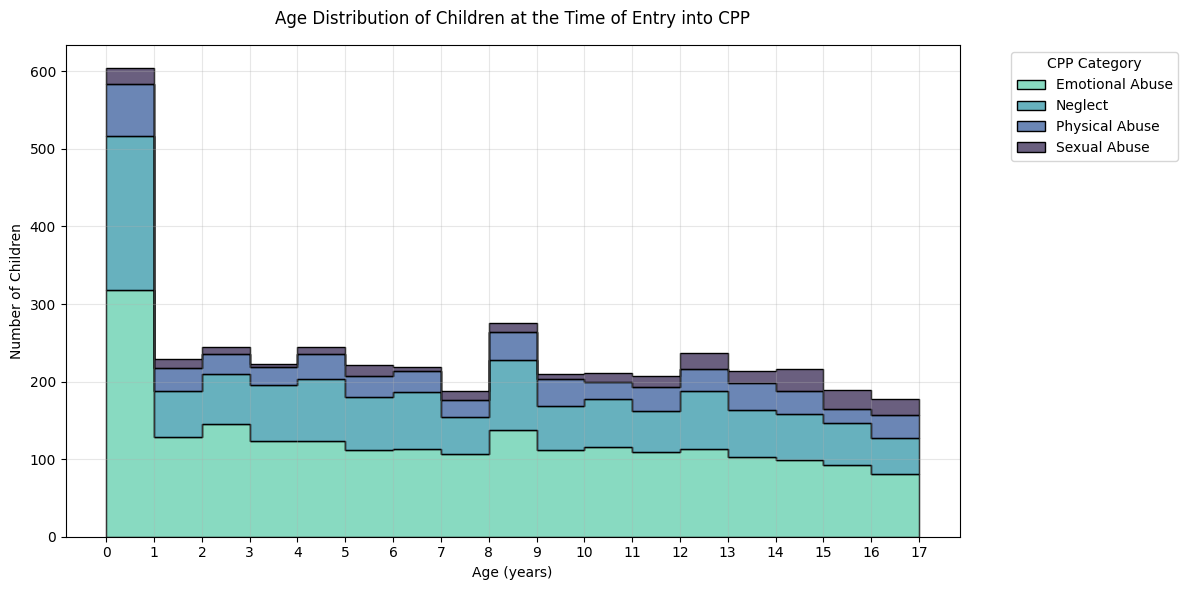

In [32]:
# Create the figure  
plt.figure(figsize=(12, 6))  

# Define the order of categories based on their counts (from highest to lowest)  
category_order = ['Emotional Abuse', 'Neglect', 'Physical Abuse', 'Sexual Abuse']  

# Create the histogram plot with ordered categories  
hist = sns.histplot(  
    data=cpp,     
    x='AgeAtEntry',     
    hue='CPP_Category',     
    multiple="stack",  
    element='step',     
    hue_order=category_order[::-1],  # Reverse the order for proper stacking  
    palette='mako',
    bins=np.arange(0, 18, 1),  
    stat='count'  
)  

# Set the title and labels  
plt.title('Age Distribution of Children at the Time of Entry into CPP', fontsize=12, pad=15)  
plt.xlabel('Age (years)', fontsize=10)  
plt.ylabel('Number of Children', fontsize=10)  

# Set x-ticks  
plt.xticks(range(0, 18, 1))  

# Customize the legend with the correct order  
plt.legend(title='CPP Category',  
          labels=category_order,  # Keep original order in legend  
          bbox_to_anchor=(1.05, 1),  
          loc='upper left')  

# Add grid for better readability  
plt.grid(True, alpha=0.3)  

# Adjust layout
plt.tight_layout()  
plt.show()

# Monthly Entry and Exit Trends in CPP

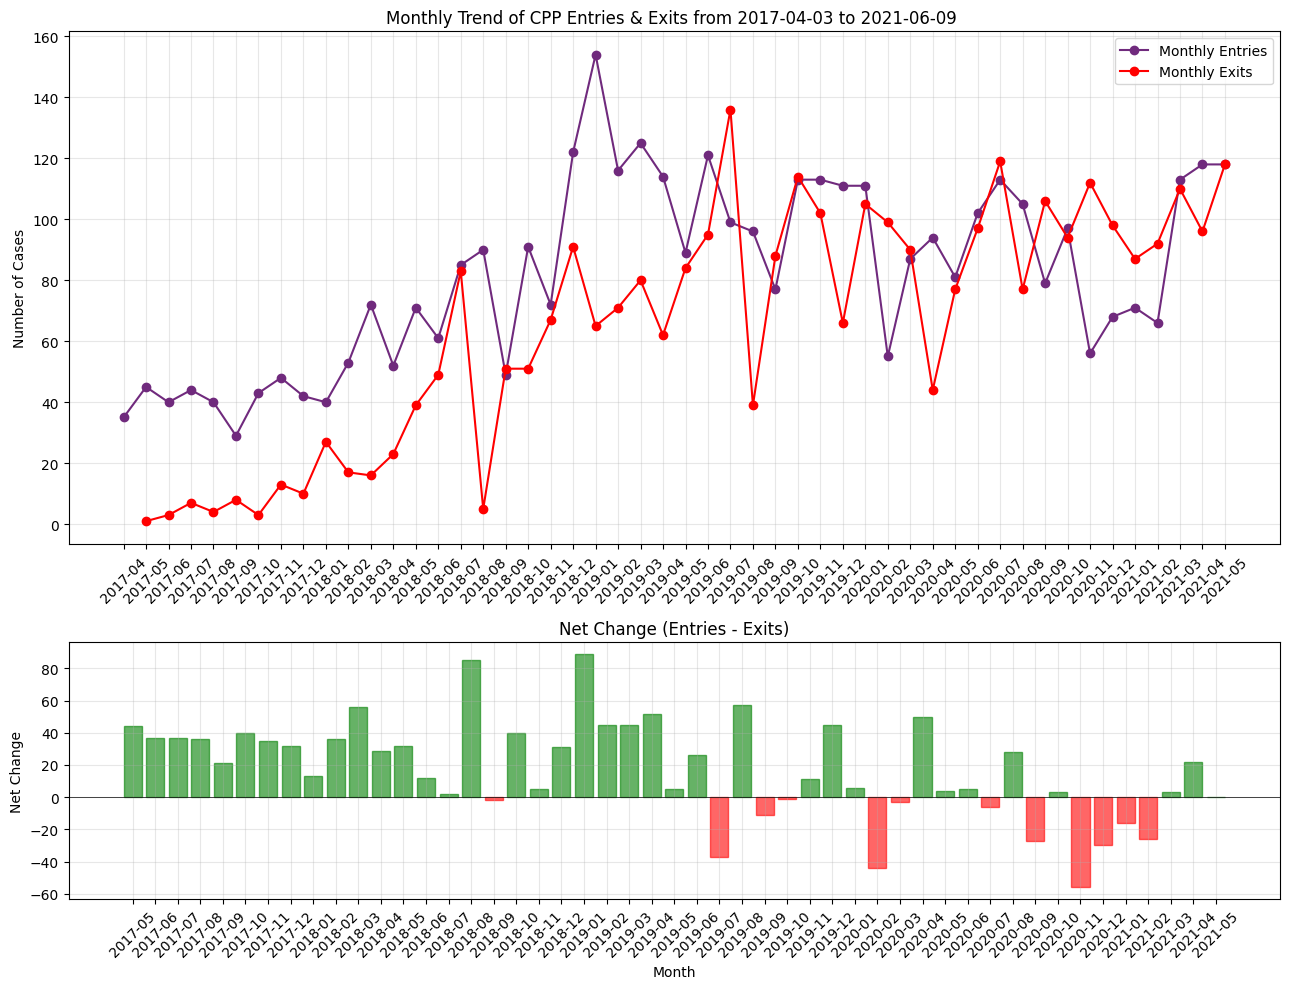


Summary of Net Changes:
Average monthly net change: 17.6
Maximum increase: 89
Maximum decrease: -56
Months with net increase: 36
Months with net decrease: 12


In [33]:
# ENTRIES

# Count entry cases per month
monthly_entries = cpp['StartDate'].dt.to_period('M').value_counts().sort_index()

# Exclude the last month
last_month = monthly_entries.index[-1]
monthly_entries = monthly_entries[monthly_entries.index != last_month]

# Convert PeriodIndex to string for plotting
monthly_entries.index = monthly_entries.index.astype(str)

# EXITS

# Count exit cases per month
monthly_exits = cpp['EndDate'].dt.to_period('M').value_counts().sort_index()

# Exclude the last month
monthly_exits = monthly_exits[monthly_exits.index != last_month]
monthly_exits.index = monthly_exits.index.astype(str)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10), height_ratios=[2, 1])

# Top plot: Entries and Exits
ax1.plot(monthly_entries.index, monthly_entries.values, marker='o', color=color, label='Monthly Entries')
ax1.plot(monthly_exits.index, monthly_exits.values, marker='o', color='red', label='Monthly Exits')
ax1.set_title(f'Monthly Trend of CPP Entries & Exits from {cpp.StartDate.min().date()} to {cpp.StartDate.max().date()} ')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Cases')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Bottom plot: Net Change
monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index) # Ensures both series have same index (months).
difference = monthly_entries_aligned - monthly_exits

# Create bar plot for difference
bars = ax2.bar(difference.index, difference.values, color='green', alpha=0.6)

# Add horizontal line at y=0
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Color bars based on positive/negative values
for bar, value in zip(bars, difference.values):
    if value < 0:
        bar.set_color('red')
    else:
        bar.set_color('green')

ax2.set_title('Net Change (Entries - Exits)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Net Change')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.savefig('../figs/EntriesVsExits.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print summary statistics
print("\nSummary of Net Changes:")
print(f"Average monthly net change: {difference.mean():.1f}")
print(f"Maximum increase: {difference.max():.0f}")
print(f"Maximum decrease: {difference.min():.0f}")
print(f"Months with net increase: {(difference > 0).sum()}")
print(f"Months with net decrease: {(difference < 0).sum()}")

______
**Observations:**
* The large decline from May 2021 to June 2021 is due to the latest start date which is 9th of June. Resulting in only 9 days of data compared to at least 28 days for other months.
* Generally there's an upward trend in children entering into the CPP
* Number of months with net increase is 3x the number of months with net decrease.

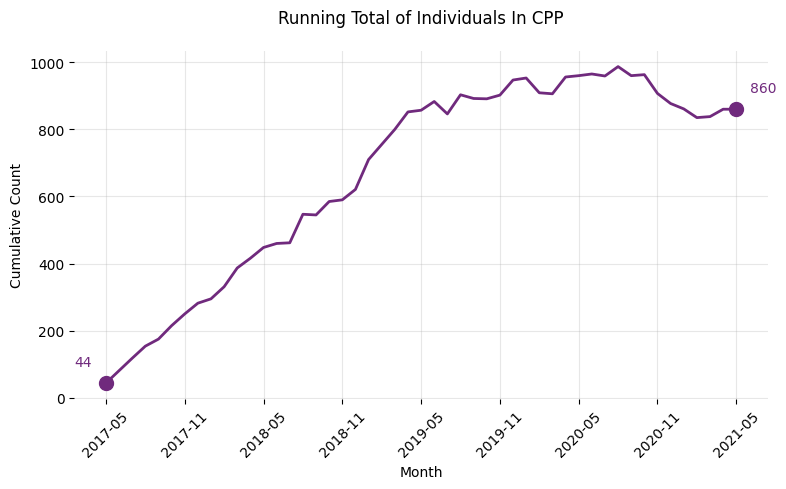

In [34]:
# Align on the same monthly index; fill_value=0 ensures missing months get zero counts
monthly_entries_aligned = monthly_entries.reindex(monthly_exits.index, fill_value=0)

# Calculate monthly net change and the cumulative sum
difference = monthly_entries_aligned - monthly_exits
cumulative_in_intervention = difference.cumsum()  # Running total

cumulative_in_intervention.index = cumulative_in_intervention.index.astype(str)

# Plot the running total
plt.figure(figsize=(8, 5))

# Plot line without markers
plt.plot(cumulative_in_intervention.index, cumulative_in_intervention.values, 
         color=color, linewidth=2)


# Add markers only at start and end points
start_date = cumulative_in_intervention.index[0]
end_date = cumulative_in_intervention.index[-1]
start_value = cumulative_in_intervention.values[0]
end_value = cumulative_in_intervention.values[-1]

# Plot markers
plt.scatter([start_date, end_date], [start_value, end_value], 
            color=color, s=100, zorder=5)

# Annotate start and end values
plt.annotate(f'{int(start_value)}', 
            xy=(start_date, start_value),
            xytext=(-10, 10),  # Offset the text slightly
            textcoords='offset points',
            ha='right',
            va='bottom',
            color=color)

plt.annotate(f'{int(end_value)}', 
            xy=(end_date, end_value),
            xytext=(10, 10),  # Offset the text slightly
            textcoords='offset points',
            ha='left',
            va='bottom',
            color=color)

# Customize the plot
plt.title('Running Total of Individuals In CPP', pad=20)
plt.xlabel('Month')
plt.ylabel('Cumulative Count')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Show every 6th month label
all_xticks = plt.gca().get_xticks()
plt.gca().set_xticks(all_xticks[::6])
plt.xticks(rotation=45)
    
# Remove chart borders
sns.despine(left=True, right=True, top=True, bottom=True)

# Save and show the plot
plt.tight_layout()
#plt.savefig('../figs/cpp_cummsum_in_intervention.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

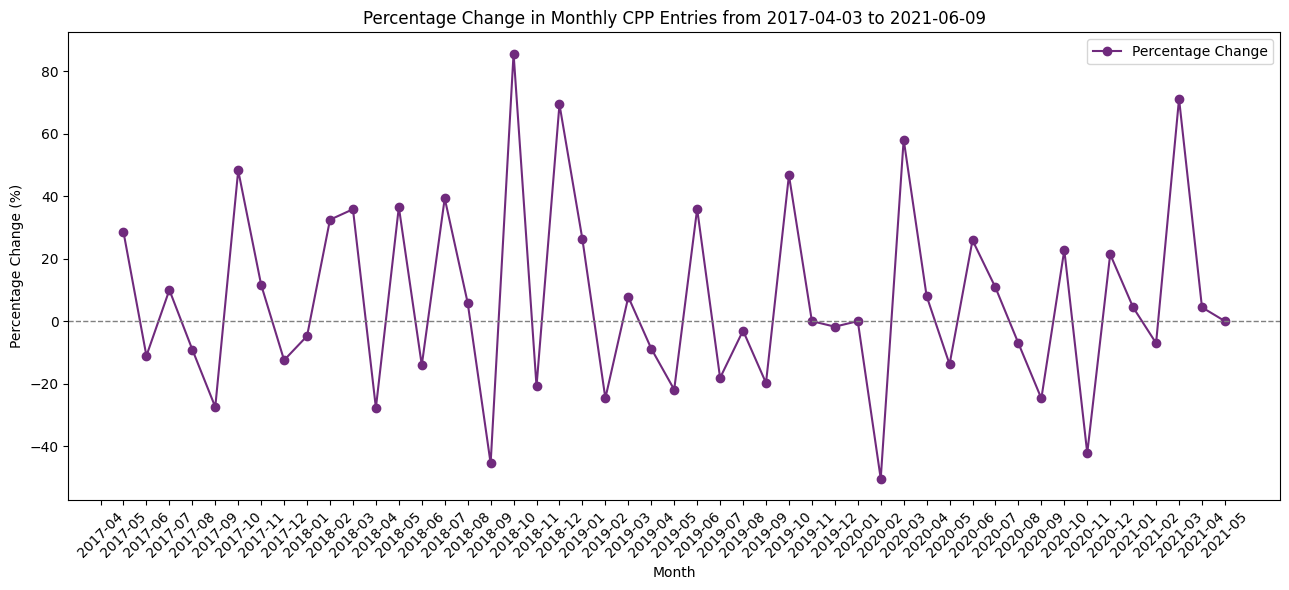

In [35]:
# Percentage change plot
# Calculate the percentage change  
percentage_change = monthly_entries.pct_change() * 100  # Convert to percentage  
  
# Plot the percentage change  
plt.figure(figsize=(13, 6))  
plt.plot(percentage_change.index, percentage_change.values, marker='o', color=color, label='Percentage Change')  
  
# Add a horizontal line at 0% for reference  
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  
  
# Add labels and title  
plt.title(f'Percentage Change in Monthly CPP Entries from {cpp.StartDate.min().date()} to {cpp.StartDate.max().date()}')  
plt.xlabel('Month')  
plt.ylabel('Percentage Change (%)')  
plt.legend()  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Number of days in intervention

In [36]:
# Subtract start date from end date to get number of days
cpp['num_of_days_in_intervention'] = (cpp['EndDate'] - cpp['StartDate']).dt.days

#Convert to integer wile preserving NA values using Int64
cpp['num_of_days_in_intervention'] = cpp['num_of_days_in_intervention'].astype('Int64')

In [37]:
# Statistics of CPP Intervention Duration
print("\nBasic Statistics of Intervention Duration:")
print(cpp['num_of_days_in_intervention'].describe().round(2))

print("\nSummary of missing values:")
print(f"Percentage missing: {(cpp['num_of_days_in_intervention'].isna().sum()/len(cpp))*100:.2f}%")


Basic Statistics of Intervention Duration:
count    3216.0
mean     260.86
std      165.91
min         1.0
25%       126.0
50%       237.0
75%       359.0
max      1091.0
Name: num_of_days_in_intervention, dtype: Float64

Summary of missing values:
Percentage missing: 21.77%


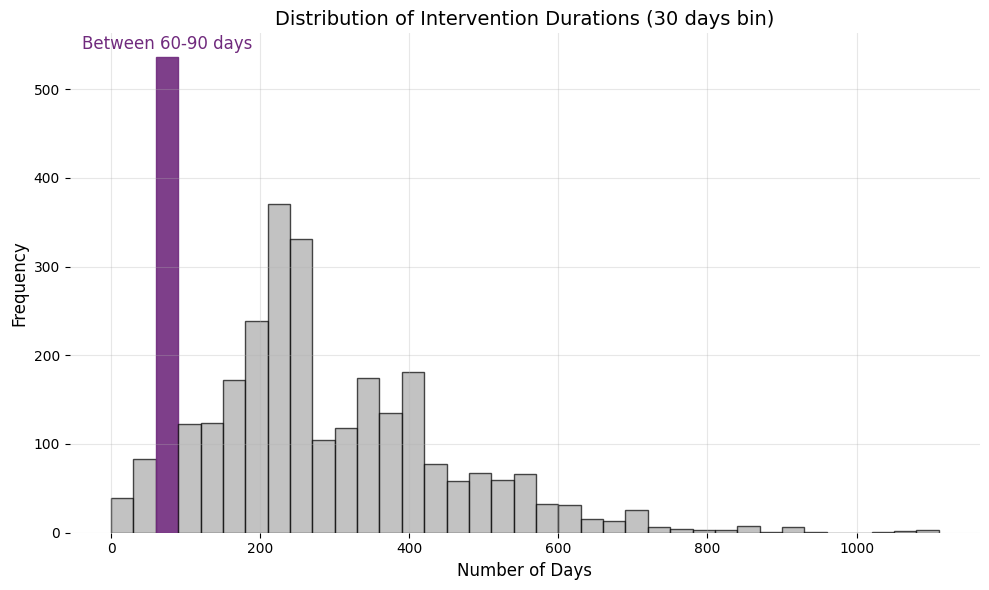

In [38]:
# Distribution of Intervention Durations

# Define the color for the non-highlighted bins
grey_color = '#A9A9A9'  

# Calculate bin edges from 0 to max value with steps of 30 days
bin_edges = np.arange(0, max(cpp['num_of_days_in_intervention'].dropna()) + 30, 30)

# Create histogram with calculated number of bins
plt.figure(figsize=(10, 6))

# Plot the histogram
n, bins, patches = plt.hist(cpp['num_of_days_in_intervention'].dropna(), 
                            bins=bin_edges,
                            color=grey_color,  # Default color for all bars
                            edgecolor='black',
                            alpha=0.7)

# Highlight the 90-day bin
for i, (patch, bin_start) in enumerate(zip(patches, bins)):
    if bin_start == 60:  # Check if the bin starts at 60 days
        patch.set_facecolor(color)  # Set the color for the 60-90 days bin
        patch.set_edgecolor(color)
        patch.set_alpha(0.9)  # Set transparency
        # Annotate the 60-90 day bin
        plt.text(bin_start + 15, n[i] + 5, 'Between 60-90 days', 
                 ha='center', va='bottom', fontsize=12, color=color, weight='normal')

# Customize the plot
plt.title('Distribution of Intervention Durations (30 days bin)', fontsize=14)
plt.xlabel('Number of Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Remove chart borders (spines)
sns.despine(left=True, right=True, top=True, bottom=True)

# Save and show the plot
plt.tight_layout()
# plt.savefig('num_of_days.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [39]:
cpp.columns

Index(['person_id', 'YearOfBirth', 'PCArea', 'EthnicOrigin', 'CPP_Category',
       'StartDate', 'EndDate', 'DateOfBirth', 'Gender', 'Year', 'AgeAtEntry',
       'num_of_days_in_intervention'],
      dtype='object')

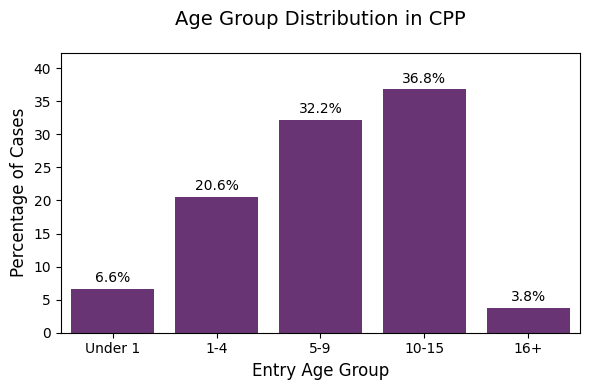

In [55]:
# Group Entry Ages
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']

# Create new age group column
cpp['entry_agegroup'] = pd.cut(cpp['AgeAtEntry'], bins=bins, labels=labels, right=True)

# Calculate percentages
age_counts = cpp['entry_agegroup'].value_counts(normalize=True).sort_index() * 100

# Plot distribution of entry age group
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=age_counts.index, y=age_counts.values, color=color)

# Add percentage labels on each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha="center", fontsize=10)

plt.title('Age Group Distribution in CPP', fontsize=14, pad=20)
plt.xlabel('Entry Age Group', fontsize=12)
plt.ylabel('Percentage of Cases', fontsize=12)
plt.ylim(0, max(age_counts.values) * 1.15)
plt.tight_layout()
plt.show()

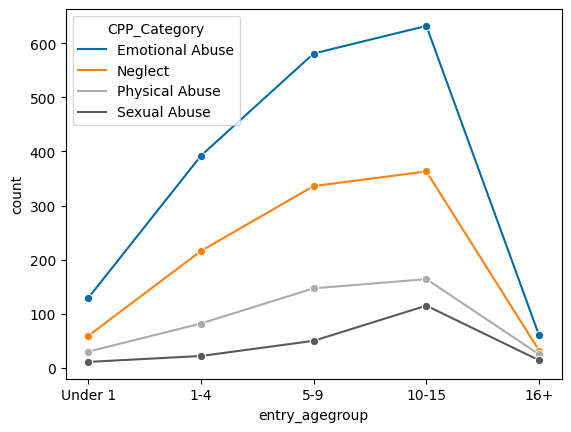

In [41]:
# Category distribution by Age Group

# Create a count DataFrame
count_df = cpp.groupby(['entry_agegroup', 'CPP_Category']).size().reset_index(name='count')

# Create the line plot
sns.lineplot(data=count_df, x='entry_agegroup', y='count', hue='CPP_Category', marker='o')

# Show the plot
plt.show()